In [1]:
# Extensions for code formatting and inline plotting
%load_ext nb_black
#%matplotlib inline

<IPython.core.display.Javascript object>

In [35]:
# Library importing
import pandas as pd
import numpy as np
import seaborn as sns
import math
import warnings
import os
import matplotlib.pyplot as plt
#import pmdarima as pm
from prophet import Prophet

warnings.filterwarnings("ignore")  # Ignoring warnings to reduce text spam.

# Preferences
sns.set(rc={"figure.figsize": (15, 8.27)})
pd.set_option("display.float_format", "{:,}".format)
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 30)

In [6]:
# Data retrieval function
def retrieve_data():
    os.chdir('..')
    cwd = os.getcwd()
    if 'data' in os.listdir():
        os.chdir(cwd + '\\data')
        df = pd.read_csv('data.csv', sep=';', decimal=',')
        df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
        df['y'] = df['quantity'].round().astype('int64')
        df.drop(columns=['year','month','quantity'], inplace=True)
        return df

In [7]:
# data object
df = retrieve_data()

In [8]:
df.head(20)

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571
5,2010-06-01,10134094
6,2010-07-01,9561953
7,2010-08-01,9845679
8,2010-09-01,12236500
9,2010-10-01,10949143


[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'quantity'),
 Text(0.5, 1.0, 'Medicine sales over time')]

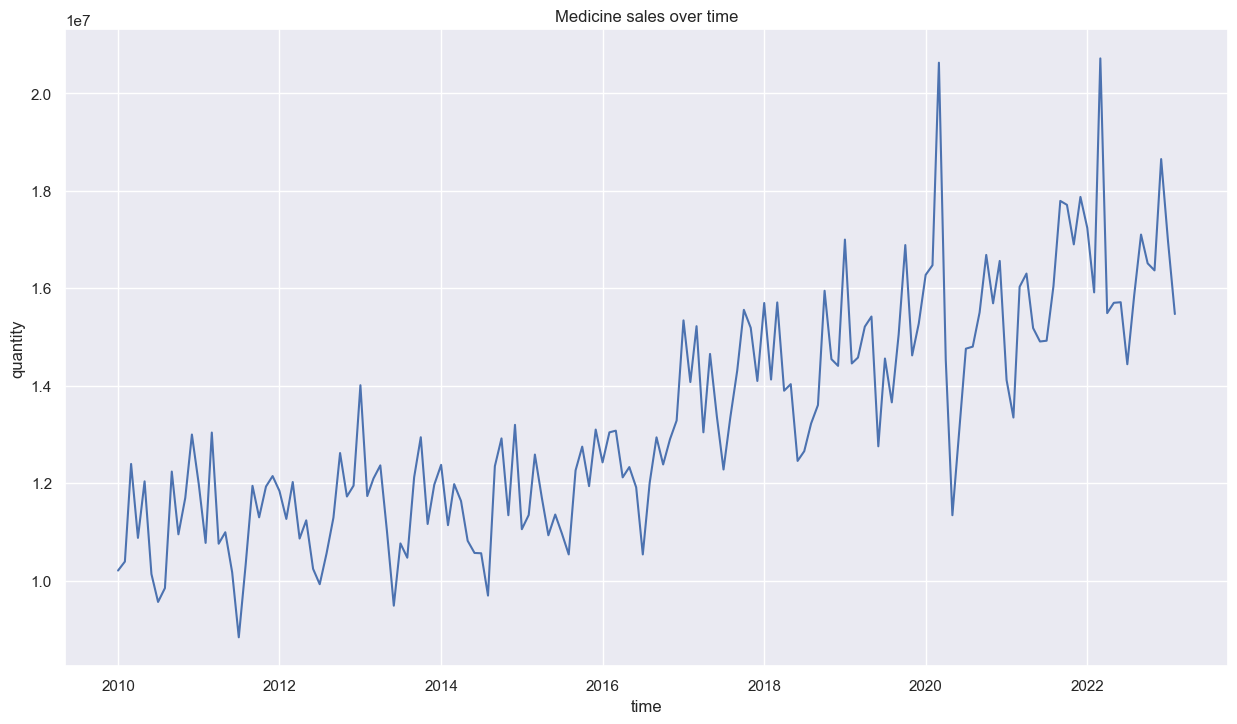

In [9]:
fig = sns.lineplot(df, x='ds', y='y')
fig.set(xlabel='time', ylabel='quantity', title='Medicine sales over time')

In [11]:
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    daily_seasonality=False,
    weekly_seasonality=False,
    interval_width=0.3,
    changepoint_range=0.7,
    changepoint_prior_scale=0.5,
   # seasonality_prior_scale=2,
)
#model.add_country_holidays(country_name="LT")
model.fit(df)
future = model.make_future_dataframe(periods=60, freq='MS', include_history=True)
forecast = model.predict(future)

22:30:57 - cmdstanpy - INFO - Chain [1] start processing
22:30:57 - cmdstanpy - INFO - Chain [1] done processing


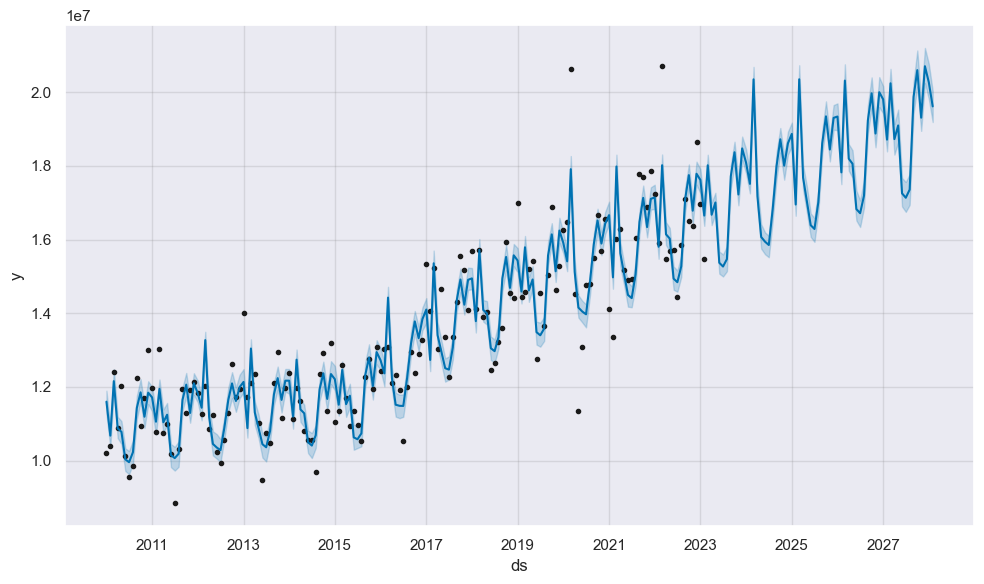

In [12]:
a = model.plot(forecast)

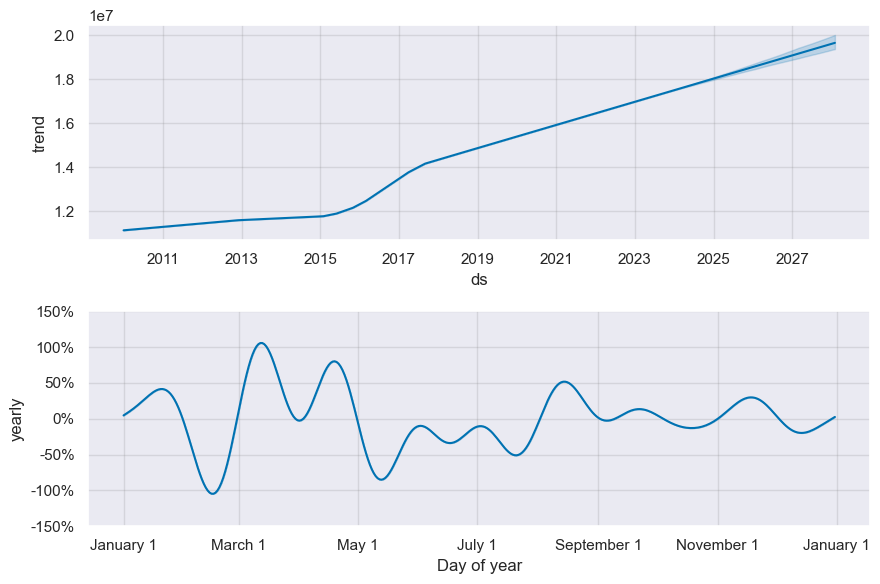

In [13]:
plt = model.plot_components(forecast)

In [49]:
def fit_predict_model(
    dataframe, 
    interval_width = 0.8,
    changepoint_range = 0.8,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10):
    m = Prophet(daily_seasonality = False, yearly_seasonality = True, weekly_seasonality = False,
               seasonality_mode = 'multiplicative',
               interval_width = interval_width,
               changepoint_range = changepoint_range,
               changepoint_prior_scale=changepoint_prior_scale,
               seasonality_prior_scale=seasonality_prior_scale)
    m = m.fit(dataframe)
    future = m.make_future_dataframe(periods=60, freq='MS', include_history=True) 
    forecast = m.predict(future)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast, m

In [15]:
pred, model = fit_predict_model(df, 0.8, 0.99)

22:31:16 - cmdstanpy - INFO - Chain [1] start processing
22:31:16 - cmdstanpy - INFO - Chain [1] done processing


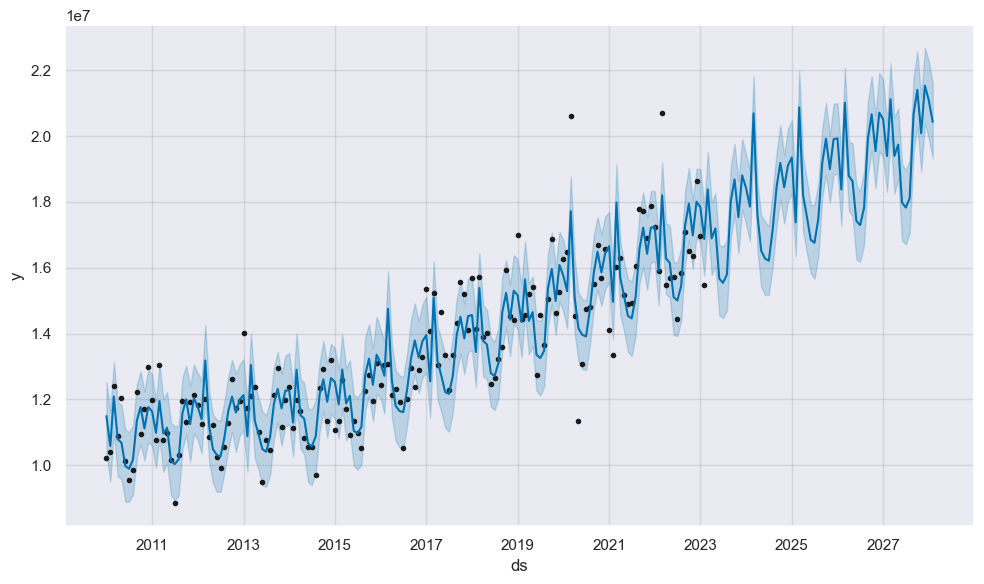

In [16]:
f = model.plot(pred)

In [17]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1
#anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted

In [46]:
pred = detect_anomalies(pred)
pred[pred['anomaly'] != 0].sort_values(by='importance')[:5]

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
110,2019-03-01,"14,717,760.726451831","15,645,183.04559066","14,586,990.153485546","16,802,560.72152654","14,575,332.0",-1,0.0007998550897877242
26,2012-03-01,"11,426,382.41075245","13,180,006.02180405","12,043,058.458309475","14,262,947.907513414","12,021,802.0",-1,0.001768159075442711
64,2015-05-01,"12,250,137.7639097","12,105,584.929985324","10,990,198.979340425","13,185,292.294963317","10,929,673.0",-1,0.005537766714559965
140,2021-09-01,"16,330,688.456175312","16,564,724.23742072","15,510,863.996495355","17,682,180.433676805","17,788,886.0",1,0.005998440055391589
11,2010-12-01,"11,194,226.299351899","11,764,354.027862202","10,710,222.184655335","12,891,896.917358408","12,996,323.0",1,0.008035048270314015


RMSE is the square root of MSE.<br>
MSE is measured in units that are the square of the target variable, while RMSE is measured in the same units as the target variable.<br>
Due to its formulation, MSE, just like the squared loss function that it derives from, effectively penalizes larger errors more severely.

In [19]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(
    model, 
    initial='731 days', 
    horizon='365 days',
    period='365 days',
    parallel = 'processes'
)

In [20]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-03-01,"12,007,813.392546922","11,837,043.82349536","12,188,270.10283415",12021802,2012-02-04
1,2012-04-01,"11,145,809.684350755","10,987,336.742571788","11,336,658.968009355",10862213,2012-02-04
2,2012-05-01,"13,662,250.72295567","13,481,198.744323252","13,835,960.091204677",11235651,2012-02-04
3,2012-06-01,"9,167,891.67900805","8,971,796.664264895","9,346,199.170022901",10240797,2012-02-04
4,2012-07-01,"10,404,353.079729186","10,219,843.281486714","10,598,871.994858462",9925310,2012-02-04


In [21]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,57 days,"2,756,236,244,711.951","1,660,191.6289127443","1,207,568.7111653646",0.07459061518973163,0.07985597440993364,0.0759811030805533,0.38461538461538464
1,58 days,"2,439,195,958,435.6455","1,561,792.5465424804","1,032,026.8023003114",0.061577050580007606,0.041453980754498125,0.06337953077956894,0.5384615384615384
2,59 days,"1,653,720,311,840.208","1,285,970.5719184277","841,826.6752508224",0.05165074736624774,0.041453980754498125,0.05286075511404441,0.6923076923076923
3,87 days,"869,245,646,626.5963","932,333.441761367","719,303.8081577569",0.05803638677949609,0.04444293668229635,0.05562836334238467,0.6923076923076923
4,88 days,"1,138,202,205,044.847","1,066,865.5983978708","879,157.536948608",0.06816477679211554,0.052520627834436256,0.0663779404885115,0.6923076923076923


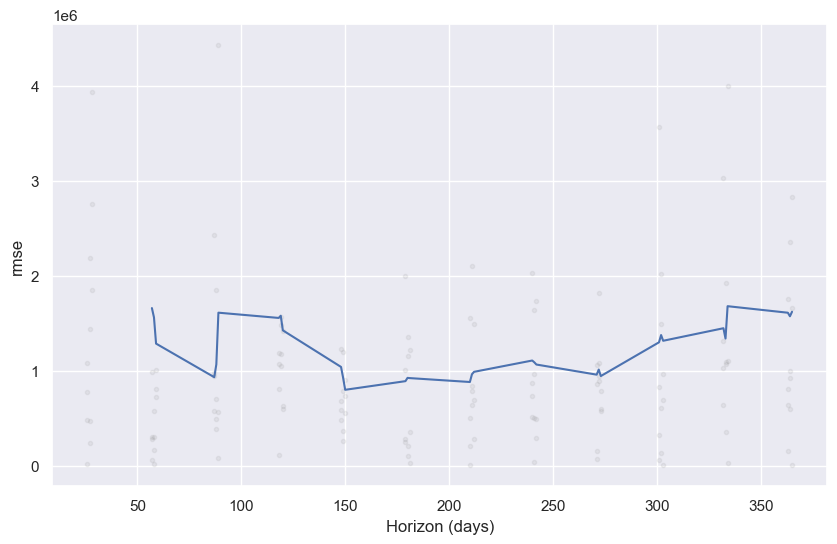

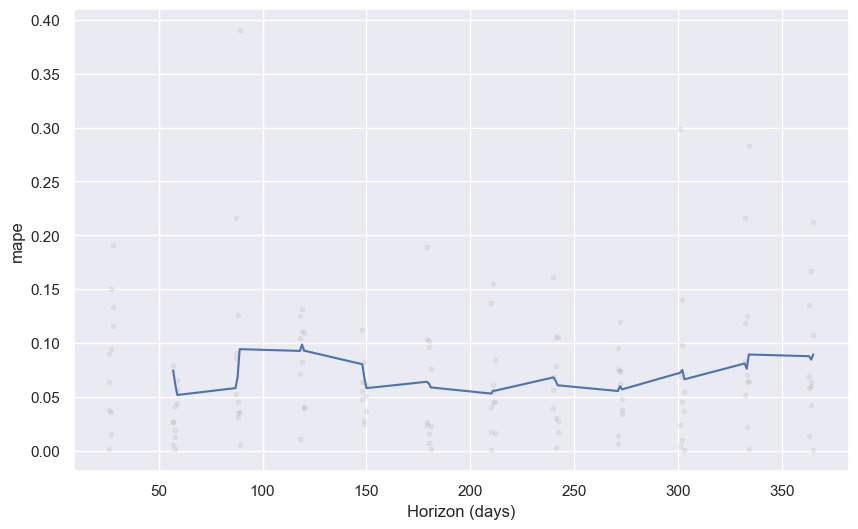

In [22]:
from prophet.plot import plot_cross_validation_metric
a = plot_cross_validation_metric(df_cv, metric='rmse')
b = plot_cross_validation_metric(df_cv, metric='mape')


The mean absolute percentage error (MAPE) is the sum of the individual absolute forecast errors, divided by the actual values for each period.
It's an accuracy measure based on the relative percentage of errors.
The closer the MAPE value is to zero, the better the predictions.

In [23]:
# Relative percentage error
df_p['mape'].mean()

0.07072524539450177

In [24]:
# Param map generated by my hyper_tuner that evalutes rmse
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'changepoint_range': 0.95}

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 0.01,
 'changepoint_range': 0.95}

In [25]:
def evaluate_model(model):
    df_cv = cross_validation(
    model, 
    initial='731 days', 
    horizon='365 days',
    period='365 days',
    parallel = 'processes')
    df_p = performance_metrics(df_cv)
    mape = df_p['mape'].mean()
    rmse = df_p['rmse'].mean()
    print(f'MAPE: {mape}\nRMSE: {rmse}')

In [27]:
evaluate_model(model)

MAPE: 0.07072524539450177
RMSE: 1226119.82707033


In [31]:
def get_anomaly_ds(predictions):
    anomaly_list = predictions[predictions['anomaly'] != 0]['ds']
    return anomaly_list

In [32]:
anomalies = get_anomaly_ds(pred)

In [42]:
def remove_anomalies(df, predictions):
    anomaly_list = predictions[predictions['anomaly'] != 0]['ds']
    return df[~df['ds'].isin(anomaly_list)]

In [43]:
dfc = remove_anomalies(df, anomalies)

In [44]:
dfc

,ds,y
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
5,2010-06-01,10134094
6,2010-07-01,9561953
...,...,...
151,2022-08-01,15846756
152,2022-09-01,17098276
154,2022-11-01,16363748
155,2022-12-01,18647412


In [ ]:
# Param map generated by my hyper_tuner that evalutes rmse
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'changepoint_range': 0.95}

In [50]:
pred2, model2 = fit_predict_model(
    dfc, 
    changepoint_prior_scale=0.1,
    seasonality_prior_scale=0.01,
    changepoint_range=0.95)

22:51:15 - cmdstanpy - INFO - Chain [1] start processing
22:51:16 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
evaluate_model(model2)

MAPE: 0.04670371030642695
RMSE: 783439.5902806821


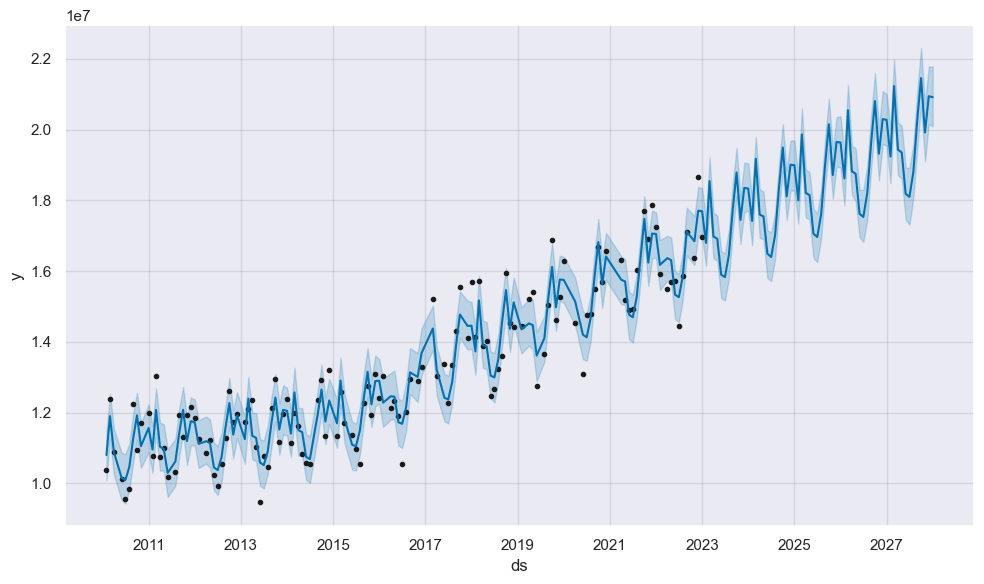

In [53]:
a = model2.plot(pred2)